# Part a): Write your own Stochastic Gradient Descent code, first step
In order to get started, we will now replace in our standard ordinary least squares (OLS) and Ridge regression codes (from project 1) the matrix inversion algorithm with our own gradient descent (GD) and SGD codes. You can use the Franke function or the terrain data from project 1. However, we recommend using a simpler function like a higher-order one-dimensional polynomials. You can obviously test your final codes against for example the Franke function.

The exercise set for week 41 should help in solving this part of the project.

You should include in your analysis of the GD and SGD codes the following elements

In [1]:
from pathlib import Path
project_root_dir = Path.cwd().parent
fig_dir = project_root_dir / 'figs'
from wand.image import Image


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functions import optimal_parameters
plt.rcParams.update({'text.usetex': True, 'font.size': 18, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 16, 'ytick.labelsize': 16})
import numpy as np
from RegressionModel import RegressionModel
from franke_example import FrankeFunction
from tqdm import tqdm
seed = 42
np.random.seed(seed)

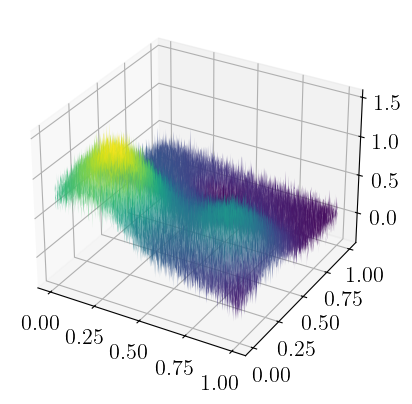

In [2]:
N  = 1000
x = np.arange(0, 1, 1/N).reshape(-1, 1)
y = np.arange(0, 1, 1/N).reshape(-1, 1)
X, Y = np.meshgrid(x, y)

noise = 0.1
z = (FrankeFunction(X, Y, noise, seed)).reshape(-1, 1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z.reshape(N, N), cmap='viridis')
plt.show()

### 1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression for the gradient.

Minimum MSE:  6.751e-03
Optimal learning rate:  2.456e-01


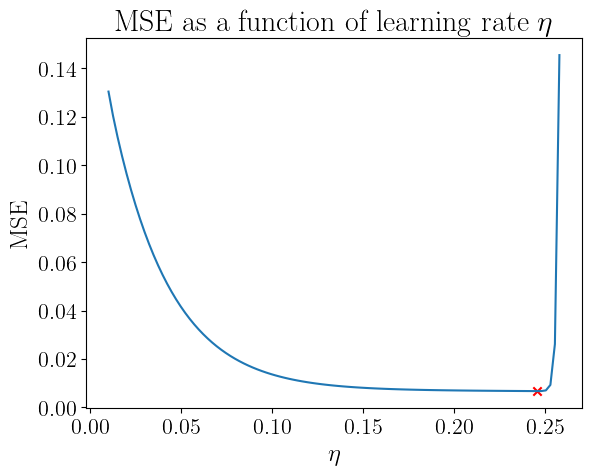

In [3]:
degree = 4
test_size = 0.2
model = RegressionModel(x, y, degree, test_size, seed=seed)
MSE_array= []
η_array = np.linspace(0.01, 0.258, 101)
for η in η_array:
    MSE, R2 = model.gradient_descent(50, eta=η)
    MSE_array.append(MSE)
print(f'Minimum MSE: {min(MSE_array): .3e}')
print(f'Optimal learning rate: {η_array[np.argmin(MSE_array)]: .3e}')

plt.plot(η_array, MSE_array)
plt.scatter(η_array[np.argmin(MSE_array)], min(MSE_array), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.show()

#### Comment
- When increasing the learning rate, we see a decrease in the MSE. 
- It stabilizes right before  0.25, and increases sharply thereafter.  


### 2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.


In [4]:
n = 50
n_iterations = 100
γ_array = np.linspace(0.875, 0.925, n)
η_array = np.linspace(0.25, .45, n)
MSE_array = np.zeros((len(η_array), len(γ_array)))
R2_array = np.zeros((len(η_array), len(γ_array)))
for i, η in enumerate(tqdm(η_array)):
    for j, γ in enumerate(γ_array):
        MSE, R2 = model.gradient_descent(n_iterations, gamma=γ, eta=η)
        MSE_array[i, j] = MSE
        R2_array[i, j] = R2

100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


#### Tuning both the learning rate and the momentum parameter

##### Overview of entire parameter space

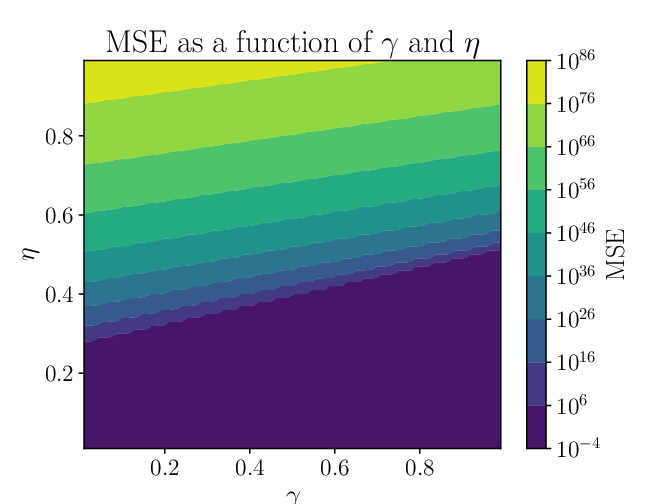

In [5]:
img = Image(filename='../figs/a_2_parameter_overview.pdf', resolution=105)
img

##### Tuned parameters

Locator attempting to generate 1759 ticks ([1.95e-05, ..., 0.0026565]), which exceeds Locator.MAXTICKS (1000).


Minimum MSE: 2.011503600004564e-05
Optimal η for MSE:  4.173e-01
Optimal γ for MSE:  9.026e-01
Maximum R2:  100.00%
Optimal η for R2:  4.173e-01
Optimal γ for R2:  9.026e-01


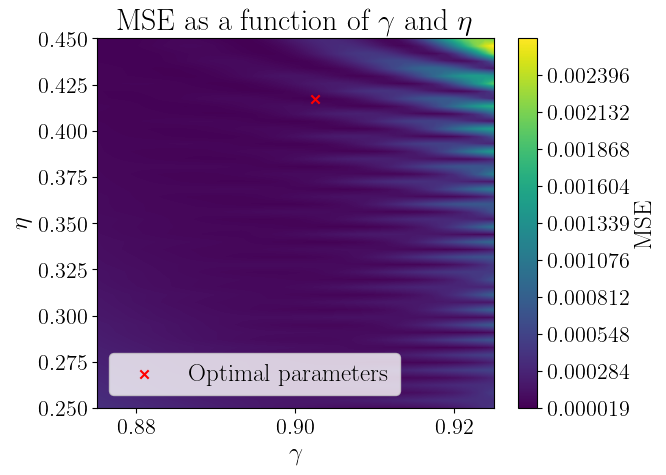

In [6]:
plt.contourf(γ_array, η_array, MSE_array, levels=n*n, cmap='viridis')
plt.colorbar(label='MSE')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\eta$')
plt.title(r'MSE as a function of $\gamma$ and $\eta$')
γ_optimal_MSE, η_optimal_MSE = optimal_parameters(MSE_array, γ_array, η_array)
γ_optimal_R2, η_optimal_R2 = optimal_parameters(R2_array, γ_array, η_array, max_or_min='max')
print(f'Minimum MSE: {np.min(MSE_array)}')
print(f'Optimal η for MSE: {η_optimal_MSE: 3.3e}')
print(f'Optimal γ for MSE: {γ_optimal_MSE: 3.3e}')

print(f'Maximum R2: {np.max(R2_array): .2%}')
print(f'Optimal η for R2: {η_optimal_R2: 3.3e}')
print(f'Optimal γ for R2: {γ_optimal_R2: 3.3e}')

plt.scatter(γ_optimal_MSE, η_optimal_MSE, color='r', label='Optimal parameters', marker='x')
plt.legend(loc='lower left')

#### Comment
- By trial and error, we closed in on the optimal parameters.
- Minimum MSE: 2.011503600004564e-05
    - Optimal η for MSE:  4.173e-01
    - Optimal γ for MSE:  9.026e-01
- Maximum R2:  100.00%
    - Optimal η for R2:  4.173e-01
    - Optimal γ for R2:  9.026e-01
- With $γ > 0.90$, we see long "hairs" of regions with higher MSE. This could suggest it would be wise to stay a bit further left of the optimal γ (0.875 to 0.90), to avoid these regions. Given a slightly different starting point, we could find our optimal parameters to suddenly be in this region.   
- The optimal $η$-values was not that important. 

 
### 3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from weeks 39 and 40. Discuss the results as functions of the various parameters (size of batches, number of epochs etc). Use the analytical gradient.

#### 3.a Fixed learning rate

In [7]:
n = 50
n_iterations = 100
dx = N/100
batch_array = np.arange(2, 80 + dx, dx, dtype=int)
η_array = np.linspace(0.1, 0.21, n)
MSE_array = np.zeros((len(η_array), len(batch_array)))
R2_array = np.zeros((len(η_array), len(batch_array)))
for i, η in enumerate(tqdm(η_array)):
    for j, m in enumerate(batch_array):
        MSE, R2 = model.stochastic_gradient_descent(n_iterations, M=m, eta=η)
        MSE_array[i, j] = MSE
        R2_array[i, j] = R2

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


Minimum MSE: 1.7657501627301383e-06
Optimal η for MSE:  2.033e-01
Optimal batch for MSE:  2.000e+00
Maximum R2:  100.00%
Optimal η for R2:  2.033e-01
Optimal batch for R2:  2.000e+00


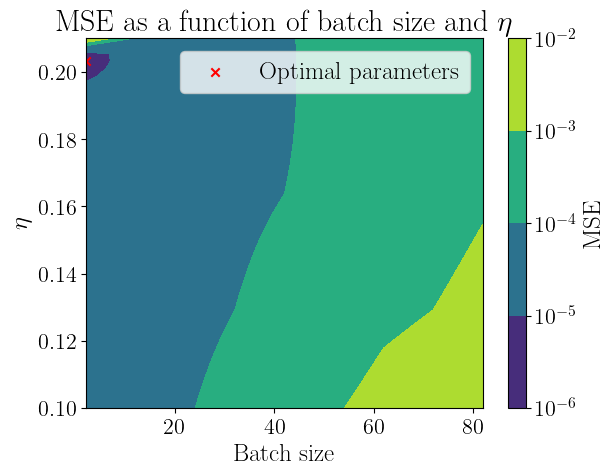

In [8]:
plt.contourf(batch_array, η_array, MSE_array, levels=n*n, cmap='viridis', norm=mcolors.LogNorm())
plt.colorbar(label='MSE')
plt.xlabel(r'Batch size')
plt.ylabel(r'$\eta$')
plt.title(r'MSE as a function of batch size and $\eta$')
batch_optimal_MSE, η_optimal_MSE = optimal_parameters(MSE_array, batch_array, η_array)
batch_optimal_R2, η_optimal_R2 = optimal_parameters(R2_array, batch_array, η_array, max_or_min='max')

print(f'Minimum MSE: {np.nanmin(MSE_array)}')
print(f'Optimal η for MSE: {η_optimal_MSE: 3.3e}')
print(f'Optimal batch for MSE: {batch_optimal_MSE: 3.3e}')

print(f'Maximum R2: {np.nanmax(R2_array): .2%}')
print(f'Optimal η for R2: {η_optimal_R2: 3.3e}')
print(f'Optimal batch for R2: {batch_optimal_R2: 3.3e}')

plt.scatter(batch_optimal_MSE, η_optimal_MSE, color='r', label='Optimal parameters', marker='x')
plt.legend()
plt.show()

##### Comment
- If this is correct, we should have a small learning rate, and small batch size. 
- This is most likely not correct, as it should take shorter time to compute, as the batch size gets larger. This is the opposite of what we see.

### 4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

#### No momentum

In [37]:
MSE, R2 = model.stochastic_gradient_descent(100, M=20, eta=0.15, tuning_method='AdaGrad', tuning_params=[.1])
print('Stochastic Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}\n')

MSE, R2 = model.gradient_descent(100, eta=0.15, tuning_method='AdaGrad', tuning_params=[1])
print('Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}')

Stochastic Gradient Descent
MSE:  2.756e-05
R2:  99.997%

Gradient Descent
MSE:  6.516e-03
R2:  99.333%


#### Momentum

In [38]:
MSE, R2 = model.stochastic_gradient_descent(100, M=20, eta=0.15, tuning_method='AdagradMomentum', tuning_params=[.1])
print('Stochastic Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}\n')

MSE, R2 = model.gradient_descent(100, eta=0.15, tuning_method='AdagradMomentum', tuning_params=[1])
print('Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}')

Stochastic Gradient Descent
MSE:  9.676e-01
R2:  0.893%

Gradient Descent
MSE:  6.516e-03
R2:  99.333%


### 5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

#### RMSprop

In [39]:
MSE, R2 = model.stochastic_gradient_descent(100, M=20, eta=0.15, tuning_method='RMSprop', tuning_params=[.1, .2])
print('Stochastic Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}\n')

MSE, R2 = model.gradient_descent(100, eta=0.15, tuning_method='RMSprop', tuning_params=[.1, .2])
print('Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}')

Stochastic Gradient Descent
MSE:  2.923e-02
R2:  97.006%

Gradient Descent
MSE:  6.516e-03
R2:  99.333%


#### Adam

In [40]:
MSE, R2 = model.stochastic_gradient_descent(100, M=20, eta=0.15, tuning_method='Adam', tuning_params=[.1, .2, .3])
print('Stochastic Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}\n')

MSE, R2 = model.gradient_descent(100, eta=0.15, tuning_method='Adam', tuning_params=[.1, .2, .3])
print('Gradient Descent')
print(f'MSE: {MSE: .3e}')
print(f'R2: {R2: .3%}')

Stochastic Gradient Descent
MSE:  9.676e-01
R2:  0.893%

Gradient Descent
MSE:  6.516e-03
R2:  99.333%
